In [1]:
# from blendinator import ProbaUNet
import numpy as np
from astropy.io import fits
import tensorflow as tf
# from train import train
from predict import predict
from predict import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow.keras as tfk

In [2]:
def asinh_norm(x, y):
    return tf.asinh(tf.divide(x, tf.math.reduce_max(x))), y


In [3]:
""" Training Parameters """
base_channels = 32
list_channels = [base_channels, 2*base_channels, 4*base_channels,
                6*base_channels, 6*base_channels, 6*base_channels, 6*base_channels]    # List of the filters to do both in the Unet and the proba part
nb_epochs = 1
batch_size = 32
lrs = np.zeros(nb_epochs) + 1.e-4 # 1e-3 * np.exp(-0.1 * np.arange(nb_epochs))
betas = np.ones(nb_epochs)

eval_every_n_step = 200

In [23]:
""" Import and preprocess data (for me, segs = ground truth)"""
checkpoint_path = "./data/checkpoints/check_test"


data_path = '/data57/hbretonniere/FVAE/FVAE_emulated_data/for_deblender/phymasks/no_structure/'
name = 'TU_FVAE_divided_1_3_re_field_0123.npy'  # there is 148996 stamps
checkpoint_path = "/data57/hbretonniere/deblending/tf2/checkpoints_deblendator/"
print("checkpoint path : ", checkpoint_path)

""" Import data """
imgs = np.expand_dims(np.load(data_path + 'stamps_WithNoise_' + name), axis=-1).astype('float32')
segs = np.expand_dims(np.load(data_path + 'stamps_seg_' + name), axis=-1)


train_slice = int(0.2 * imgs.shape[0])
eval_slice = int(0.3 * imgs.shape[0])
train_steps_per_epoch = int(train_slice / batch_size)

train_data = tf.data.Dataset.from_tensor_slices((imgs[:train_slice], segs[:train_slice])).shuffle(100000, reshuffle_each_iteration=True).map(asinh_norm).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
eval_data = tf.data.Dataset.from_tensor_slices((imgs[train_slice:eval_slice], segs[train_slice:eval_slice])).shuffle(100000, reshuffle_each_iteration=True).map(asinh_norm).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_images = imgs[train_slice:train_slice+10, :, :, :]
test_segs = segs[train_slice:train_slice+10]

print('test images shape : ', imgs.shape)
print('test images shape : ', test_images.shape)


checkpoint path :  /data57/hbretonniere/deblending/tf2/checkpoints_deblendator/
test images shape :  (148996, 128, 128, 1)
test images shape :  (10, 128, 128, 1)


In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.train import latest_checkpoint
import tensorflow.keras as tfk
import sys

from blendinator.models.combinatory import combinatory
from blendinator.models.unet import unet
from blendinator.models.encoders import image_encoder, image_with_label_encoder
from blendinator.loss import cross_entropy

class ProbaUNet:
    """ProbaUNet
    
    Attributes
    ----------

    latent_dim : int
        Dimension of the latent space (dimension of the Multivariate Gaussian Normal)

    block_size : int
        Number of convolution layers in each block

    channels : list of int
        List of channels for the successive downblocks

    last_conv : int
        Number of convolution layers to apply to the output of the Unet and the gaussian encoder

    """
    def __init__(self, input_shape, latent_dim, channels, block_size, last_conv, optimizer=None):
        
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.channels = channels
        self.block_size = block_size
        self.last_conv = last_conv
        self.optimizer = optimizer if optimizer else tfk.optimizers.Adam 
        
        self._setup_model()
        
    def _setup_model(self):
        """ Create the different sub models of the Proba Unet ;
        - the unet, which ouput a 3 classes temporary segmap 
        - the img_encoder, which output a latent_dim dimensional gaussian from the input image
        - the img_with_label_encoder, which output a latent_dim dimensional gaussian from a concatenation of the input image and the corresponding segmentation map (label)
        - the last_CNN, which convolves (last_conv times) a concatenation of the output of the unet and one of the two encoder to produce the final seg map
        The two others model are just a combination of the others, but do not have any specific weights. It's the ProbaUnet in training mode (sampling from the imng_encoder_with_labels) and the ProbaUnet in prediction mode (sampling from the img_encoder). Updating one or the other just update the previously explained models."""
        
        self.unet = unet(self.input_shape, self.channels, self.block_size)
        self.img_encoder = image_encoder(self.input_shape, self.channels, self.block_size, self.latent_dim)
        self.img_with_label_encoder = image_with_label_encoder(self.input_shape, self.channels, self.block_size, self.latent_dim)
        self.last_CNN = combinatory(self.latent_dim, self.input_shape, self.last_conv)
        self.training_model = self._init_training_model()
        self.prediction_model = self._init_prediction_model()

    def _init_training_model(self):
        """ Create the Proba Unet used for training, using the other sub models """
        
        img_input = tfk.layers.Input(shape=self.input_shape, name='image')
        label_input = tfk.layers.Input(shape=self.input_shape, name= 'label')

        unet_output = self.unet(img_input)
        img_encoder_output = self.img_encoder([img_input])
        img_with_label_encoder_output = self.img_with_label_encoder([img_input, label_input])

        seg_map = self.last_CNN([
            unet_output, 
            img_with_label_encoder_output])

        return tfk.Model(
            inputs=[img_input, label_input],
            outputs=[seg_map, img_encoder_output, img_with_label_encoder_output],
            name="ProbaUNet_training")

    def _init_prediction_model(self):
        """ Create the Proba Unet used for prediction, using the other sub models """
        
        img_input = tfk.layers.Input(shape=self.input_shape, name='image')
        output = self.last_CNN([
            self.unet(img_input), 
            self.img_encoder(img_input)])

        return tfk.Model(img_input, output, name='ProbaUnet_prediction')

    def eval_step(self, features, labels, beta):
        punet_output = self.model([features, labels])
        return cross_entropy(label, punet_output, beta)

    def train_step(self, features, labels, lr, beta):
        """ Run the Punet in training mode (training_model), compute the loss and update the weights of all the submodels for one batch. Return the total loss, the reconstruction loss and the KL. """
        
        with tf.GradientTape() as tape:
            punet_output = self.training_model([features, labels])
            total_loss, rec_loss, kl_loss = cross_entropy(self.latent_dim, labels, punet_output, beta)
            grads = tape.gradient(total_loss, self.training_model.trainable_variables)
        self.optimizer(lr).apply_gradients(zip(grads, self.training_model.trainable_variables))
        return [total_loss, rec_loss, kl_loss]

    def save_weights(self, epoch, checkpoint_path):
        """ Save the weights of all the submodels, with a name corresponding to the current training step """
        
        self.unet.save_weights(f'{checkpoint_path}/unet_weights/epoch_{epoch+1}')
        self.img_encoder.save_weights(f'{checkpoint_path}/img_encoder_weights/epoch_{epoch+1}')
        self.img_with_label_encoder.save_weights(f'{checkpoint_path}/img_with_label_encoder_weights/epoch_{epoch+1}')
        self.last_CNN.save_weights(f'{checkpoint_path}/model_combiner_weights/epoch_{epoch+1}')
        return()

    def load_weights(self, checkpoint_path):
        """ Load the weights into all the submodels of the PUnet, according to the epoch written in the `checkpoint` file inside the checkpoint_path"""
        self.unet.load_weights(latest_checkpoint(f'{checkpoint_path}/unet_weights/'))
        self.img_encoder.load_weights(latest_checkpoint(f'{checkpoint_path}/img_encoder_weights/'))
        self.img_with_label_encoder.load_weights(latest_checkpoint(f'{checkpoint_path}/img_with_label_encoder_weights/'))
        self.last_CNN.load_weights(latest_checkpoint(f'{checkpoint_path}/model_combiner_weights/'))
        return()

    def plot_prediction(self, features, labels, nb_to_plot, mode):
        
        import matplotlib.pyplot as plt
        if mode == 'predict':
            predictions = self.training_model([features, labels])
        elif mode == 'training':
            predictions = self.prediction_model([features])
        else :
            sys.exit("You must chose the mode of prediction : 'predict' to use the ProbaUnet in prediction mode, 'training' for training mode")

        fig, ax = plt.subplots(nb_to_plot, 3, figsize=(nb_to_plot*2, int(nb_to_plot/3*nb_to_plot*2)))
        ax[0, 0].set_title('Input Image')
        ax[0, 1].set_title('Input Gt')
        ax[0, 2].set_title('Predicted segmap')
        
        for i in range(nb_to_plot):
            segmap = np.argmax(predictions[i], axis=-1)
            ax[i, 0].imshow(features[i, :, :, 0])
            ax[i, 1].imshow(labels[i, :, :, 0])
            ax[i, 2].imshow(segmap)
            
        return

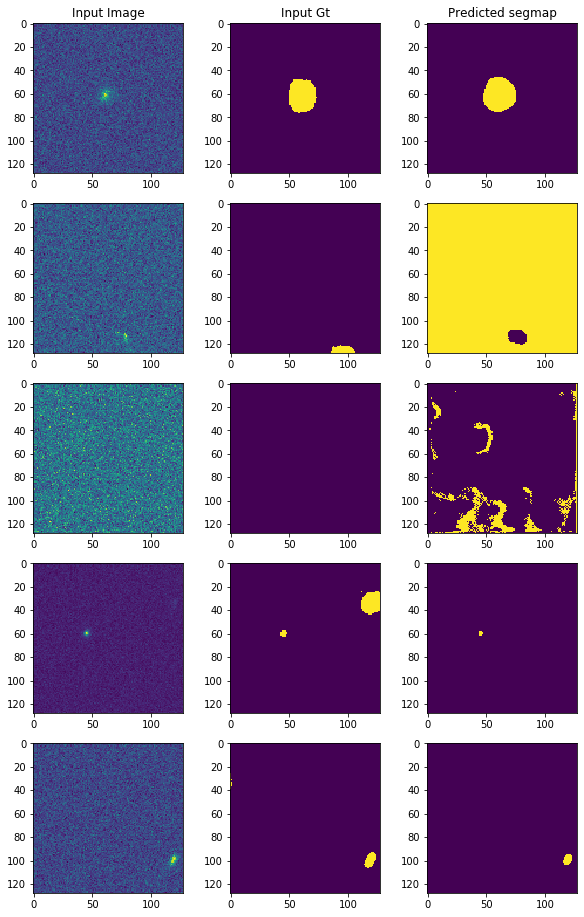

In [61]:
PUNet_r = ProbaUNet((128, 128, 1), 10, list_channels, 1, 1)
PUNet_r.load_weights(checkpoint_path)
PUNet_r.plot_prediction(asinh_norm(imgs[-10:], segs[-10:])[0], segs[-10:], 5, 'training')

In [25]:
PUnet = ProbaUNet((128, 128, 1), 10, list_channels, 1, 1, optimizer=tfk.optimizers.Adam)


In [26]:
PUnet.training_model.summary()
PUnet.prediction_model.summary()
PUnet.training_model.summary()


Model: "ProbaUNet_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
label (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
unet (Model)                    (None, 128, 128, 3)  3809155     image[0][0]                      
__________________________________________________________________________________________________
image_with_label_encoder (Model (None, 20)           1314100     image[0][0]                      
                                                                 label[0][0]     

In [27]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [29]:
def train(PUNet, train_data, epochs, step_per_epoch,
    lrs, betas, history, checkpoint_path, save_frequency=1):
    with tf.device('GPU:0'):
        with tqdm(total=epochs, desc='Epoch', position=0) as bar1:
            for epoch in range(epochs):
                bar1.update(1)
                with tqdm(total=step_per_epoch, desc='batch', position=1) as bar2:
                    for batch_nb, (image, label) in enumerate(train_data):
                        bar2.update(1)
                        total_loss, rec_loss, kl_loss = PUNet.train_step(image, label, lrs[epoch], betas[epoch])
                        history[0].append(total_loss)
                        history[1].append(rec_loss)
                        history[2].append(kl_loss)

                        # if k % eval_every_n_step == 0:
                        #     val_tot, val_rec, val_kl = 0, 0, 0
                        #     for valid,(image, label) in enumerate(eval_data):
                        #         total_loss, rec_loss, kl_loss = PUNet.eval_step(image, label)
                        #         val_tot += total_loss
                        #         val_rec += rec_loss
                        #         val_kl += kl_loss

                        #     eval_loss_results.append(val_tot/valid)
                        #     eval_rec_loss_results.append(val_rec/valid)
                        #     eval_kl_loss_results.append(val_kl/valid)
                        bar2.set_description(f"PUnet, loss={history[0][-1]}")
                        # k+=1
                if epoch % save_frequency == 0:
                    PUNet.save_weights(epoch, checkpoint_path)
    return(history)

In [30]:
history = [[],[],[]]

history = train(PUnet, train_data, nb_epochs, train_steps_per_epoch, lrs, betas, history, checkpoint_path)


PUnet, loss=4926.9052734375:   5%|▌         | 50/931 [00:26<04:49,  3.05it/s]


PUnet, loss=1848.8524169921875:  11%|█         | 99/931 [00:43<04:35,  3.02it/s]


PUnet, loss=1981.7432861328125:  16%|█▌        | 148/931 [00:59<04:31,  2.89it/s]


PUnet, loss=1556.2930908203125:  21%|██        | 196/931 [01:15<04:07,  2.97it/s]


PUnet, loss=2040.98291015625:  26%|██▋       | 245/931 [01:31<03:50,  2.98it/s]


PUnet, loss=1345.4365234375:  31%|███▏      | 293/931 [01:48<03:35,  2.96it/s]   


PUnet, loss=2035.0677490234375:  37%|███▋      | 342/931 [02:04<03:20,  2.94it/s]


PUnet, loss=1350.7169189453125:  42%|████▏     | 390/931 [02:21<03:02,  2.96it/s]


PUnet, loss=1149.2662353515625:  47%|████▋     | 439/931 [02:37<02:43,  3.01it/s]


PUnet, loss=1697.89501953125:  52%|█████▏    | 487/931 [02:54<02:29,  2.98it/s] 


PUnet, loss=1417.678466796875:  58%|█████▊    | 536/931 [03:10<02:13,  2.95it/s]


PUnet, loss=1453.9786376953125:  63%|██████▎   | 584/931 [03:27<01:58,  2.94it/s]


PUnet, loss=1267.015380859375:  68%|██████▊   | 633/931 [03:43<01:44,  2.84it/s]


PUnet, loss=1218.910888671875:  73%|███████▎  | 681/931 [04:00<01:25,  2.93it/s] 


PUnet, loss=1284.7332763671875:  78%|███████▊  | 730/931 [04:16<01:06,  3.01it/s]


PUnet, loss=1531.8262939453125:  84%|████████▎ | 778/931 [04:32<00:51,  3.00it/s]


PUnet, loss=1627.9056396484375:  89%|████████▉ | 827/931 [04:49<00:35,  2.90it/s]


PUnet, loss=996.3240966796875:  94%|█████████▍| 875/931 [05:06<00:19,  2.86it/s] 


PUnet, loss=2380.354736328125:  99%|█████████▉| 924/931 [05:22<00:02,  3.01it/s]


PUnet, loss=1651.5804443359375: 100%|██████████| 931/931 [05:24<00:00,  3.02it/s]
PUnet, loss=1651.5804443359375: : 932it [07:18,  2.12it/s]                       
Epoch: 100%|██████████| 1/1 [07:18<00:00, 438.89s/it]


KeyboardInterrupt: 

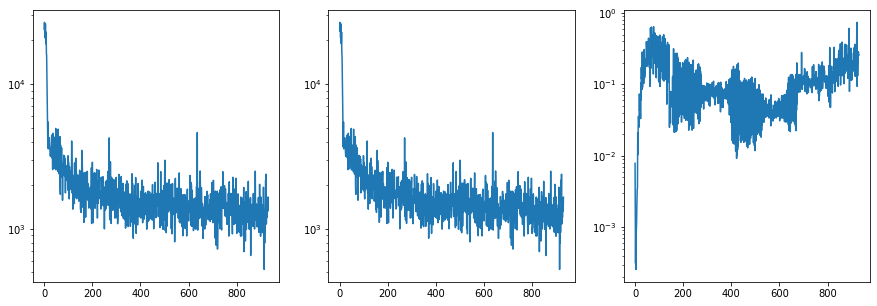

In [31]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(history[0])
ax[0].set_yscale('log')
ax[1].plot(history[1])
ax[1].set_yscale('log')
ax[2].plot(history[2])
ax[2].set_yscale('log')

()

TypeError: Invalid shape (5, 128, 128, 1) for image data

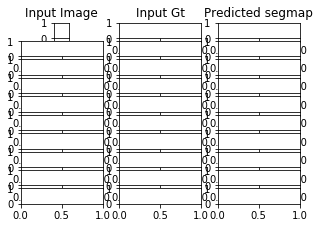

In [14]:
PUNet_restored = ProbaUNet((128, 128, 1), 10, list_channels, 1, 1)
PUNet_restored.load_weights(checkpoint_path)

()

In [24]:
PUNet_restored.prediction_model.summary()

Model: "ProbaUnet_prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
unet (Model)                    (None, 128, 128, 3)  3809155     image[0][0]                      
__________________________________________________________________________________________________
image_encoder (Model)           (None, 20)           1313812     image[0][0]                      
__________________________________________________________________________________________________
Combinatory (Model)             (None, 128, 128, 3)  42          unet[2][0]                       
                                                                 image_encoder[

In [66]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np

@tf.function
def predict(PUNet, images, nb_realisation):
    nb_image = images.shape[0]
    predictions = np.zeros((nb_image, nb_realisation, images.shape[1], images.shape[2]))
    for realisation in range(nb_realisation):
        sample = PUNet.prediction_model(images)
        predictions[:, realisation, :, :] = np.argmax(sample.eval, axis=-1) # .eval because of the decorator wich make the function tensorflow graph like
    return predictions

def summary(predictions, threshold_iso, threshold_blend):
    shape = (3,) + (np.shape(predictions)[0],) + np.shape(predictions)[2:]
    print('shape :', shape)
    summaries = np.zeros(shape)
    summaries[0] = np.mean(predictions, axis=1)
    summaries[1] = np.var(predictions, axis=1)
    summaries[2] = np.where(summaries[1]>threshold_iso, 1, 0)
    summaries[2] = np.where(summaries[1]>threshold_blend, 2, summaries[2])
    return(summaries)

In [61]:
predictions.shape

TensorShape([10, 5, 128, 128])

In [89]:
predictions = predict(PUNet_restored, test_images, 5)
summaries = summary(predictions, 0.5, 1.01)

shape : (3, 10, 128, 128)


In [90]:
predictions.shape

TensorShape([10, 5, 128, 128])

In [91]:
summaries.shape

(3, 10, 128, 128)

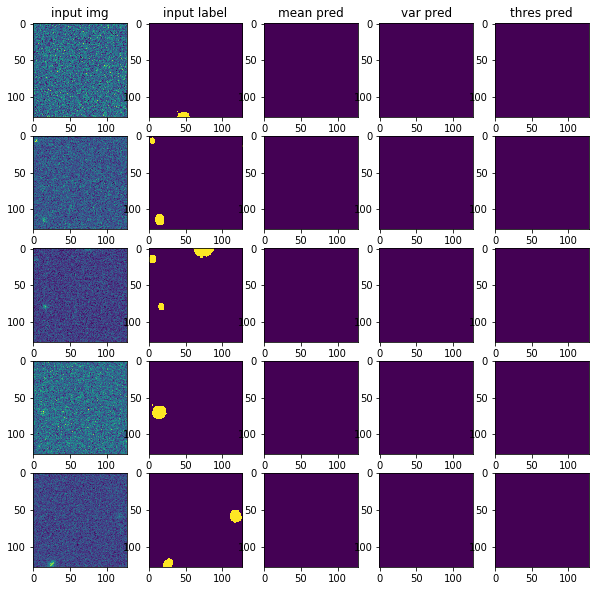

In [69]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
ax[0, 0].set_title('input img')
ax[0, 1].set_title('input label')
ax[0, 2].set_title('mean pred')
ax[0, 3].set_title('var pred')
ax[0, 4].set_title('thres pred')
for i in range(5):
    ax[i, 0].imshow(test_images[i, :, :, 0])
    ax[i, 1].imshow(test_segs[i, :, :, 0])
    ax[i, 2].imshow(summaries[0, i])
    ax[i, 3].imshow(summaries[1, i])
    ax[i, 4].imshow(summaries[2, i])

plt.show()

In [124]:
plot_image, plot_label = imgs[10:15], segs[10:15]
sample = PUnet.training_model(plot_image)

AssertionError: Could not compute output Tensor("Combinatory/Identity:0", shape=(None, 128, 128, 3), dtype=float32)

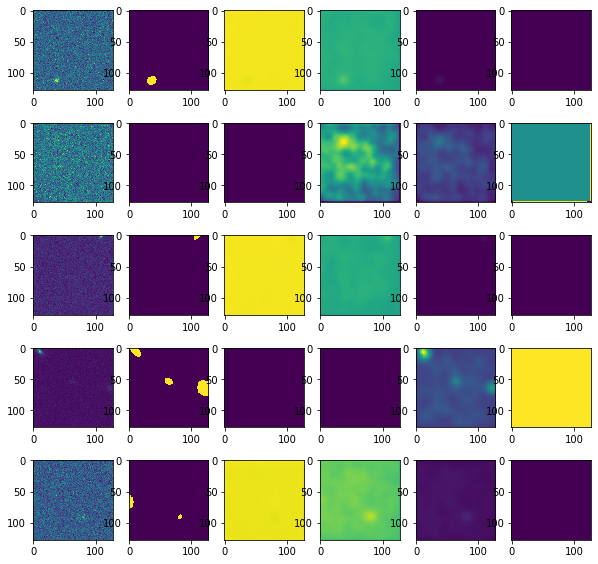

In [123]:
fig, ax = plt.subplots(5, 6, figsize=(10,10))
for i in range(5):
    ax[i, 0].imshow(plot_image[i, :, :, 0])
    ax[i, 1].imshow(plot_label[i, :, :, 0])
    for j in range(3):
        ax[i, 2+j].imshow(sample[i, :, :, j], vmin=np.min(sample[i]),
                          vmax=np.max(sample[i]))
    ax[i, 5].imshow(np.argmax(sample[i], axis=-1), vmin=0, vmax=2)

In [3]:
def train_with_plot(PUNet, train_data, epochs, step_per_epoch,
    lrs, betas, history, checkpoint_path, plot_data, save_frequency=1, plot_frequency=100):
    import matplotlib.pyplot as plt
    
    plot_image, plot_label = plot_data[0], plot_data[1]
    
    with tf.device('GPU:0'):
        with tqdm(total=epochs, desc='Epoch', position=0) as bar1:
            for epoch in range(epochs):
                bar1.update(1)
                with tqdm(total=step_per_epoch, desc='batch', position=1) as bar2:
                    for batch_nb, (image, label) in enumerate(train_data):
                        bar2.update(1)
                        total_loss, rec_loss, kl_loss = PUNet.train_step(image, label, lrs[epoch], betas[epoch])
                        history[0].append(total_loss)
                        history[1].append(rec_loss)
                        history[2].append(kl_loss)
                        bar2.set_description(f"PUnet, loss={history[0][-1]}")

                        if batch_nb % plot_frequency == 0 :
                            predictions = np.zeros((plot_image.shape[0], 10, plot_image.shape[1], plot_image.shape[2]))

                            for realisation in range(10):
                                sample = PUNet.prediction_model(plot_image)
                                predictions[:, realisation, :, :] = np.argmax(sample.eval, axis=-1) # .eval because of the decorator wich make the function tensorflow graph like
                            summaries = summary(predictions, 0.5, 1.01)
                            print(sample.shape)
                            fig, ax = plt.subplots(5, 6, figsize=(10,10))
                            for i in range(5):
                                ax[i, 0].imshow(plot_image[i, :, :, 0])
                                ax[i, 1].imshow(plot_label[i, :, :, 0])
                                for j in range(3):
                                    ax[i, 2+j].imshow(sample[i, :, :, j], vmin = np.min(sample[:, :, j]),
                                                     vmax = np.max(sample[:, :, j]))
                                ax[i, 5].imshow(np.argmax(sample[i], axis=-1))
                                plt.savefig(f'./images/training_noargmax_img_step_{epoch*step_per_epoch + batch_nb}')

                            fig, ax = plt.subplots(5, 5, figsize=(10,10))
                            for i in range(5):
                                ax[i, 0].imshow(plot_image[i, :, :, 0])
                                ax[i, 1].imshow(plot_label[i, :, :, 0])
                                ax[i, 2].imshow(summaries[0, i])
                                ax[i, 3].imshow(summaries[1, i])
                                ax[i, 4].imshow(summaries[2, i], vmin=0, vmax=2)
                                plt.savefig(f'./images/training_img_step_{epoch*step_per_epoch + batch_nb}')

    return(history)

In [137]:
PUNet_plot = ProbaUNet((128, 128, 1), 10, list_channels, 1, 1)


In [138]:
plt.ioff()

lrs = np.zeros(nb_epochs) + 1.e-4 # 1e-3 * np.exp(-0.1 * np.arange(nb_epochs))

hist = train_with_plot(PUNet_plot, train_data, 1, train_steps_per_epoch, lrs, betas, [[],[],[]]
, checkpoint_path, [imgs[10:15], segs[10:15]])

PUnet, loss=21096.173828125:   0%|          | 1/4423 [00:37<44:43:00, 36.40s/it]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=4028.593994140625:   1%|          | 50/4423 [01:09<24:05,  3.03it/s]


PUnet, loss=1853.5517578125:   2%|▏         | 99/4423 [01:25<23:30,  3.07it/s]


PUnet, loss=1493.7020263671875:   2%|▏         | 101/4423 [01:26<23:35,  3.05it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=2186.604248046875:   3%|▎         | 149/4423 [01:58<23:14,  3.06it/s]


PUnet, loss=1706.091552734375:   4%|▍         | 197/4423 [02:14<23:09,  3.04it/s]


PUnet, loss=1865.0255126953125:   5%|▍         | 201/4423 [02:16<23:00,  3.06it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1348.4951171875:   6%|▌         | 249/4423 [02:48<24:32,  2.83it/s]


PUnet, loss=1560.9097900390625:   7%|▋         | 297/4423 [03:03<22:33,  3.05it/s]


PUnet, loss=1767.09228515625:   7%|▋         | 301/4423 [03:05<22:54,  3.00it/s]  

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1274.4178466796875:   8%|▊         | 349/4423 [03:36<22:20,  3.04it/s]


PUnet, loss=1299.4725341796875:   9%|▉         | 396/4423 [03:52<22:15,  3.01it/s]


PUnet, loss=1056.85546875:   9%|▉         | 401/4423 [03:54<22:12,  3.02it/s]    

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1309.176513671875:  10%|█         | 449/4423 [04:26<22:31,  2.94it/s]


PUnet, loss=2092.006591796875:  11%|█         | 496/4423 [04:42<21:22,  3.06it/s] 


PUnet, loss=976.1331176757812:  11%|█▏        | 501/4423 [04:43<21:35,  3.03it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1357.263427734375:  12%|█▏        | 549/4423 [05:14<21:04,  3.06it/s]


PUnet, loss=982.2039794921875:  13%|█▎        | 597/4423 [05:30<21:09,  3.01it/s]


PUnet, loss=1338.8480224609375:  14%|█▎        | 601/4423 [05:32<20:58,  3.04it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1485.1728515625:  15%|█▍        | 649/4423 [06:04<20:29,  3.07it/s]


PUnet, loss=1020.1552734375:  16%|█▌        | 696/4423 [06:20<20:18,  3.06it/s]   


PUnet, loss=1252.5137939453125:  16%|█▌        | 701/4423 [06:21<20:21,  3.05it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1323.6324462890625:  17%|█▋        | 749/4423 [06:52<20:04,  3.05it/s]


PUnet, loss=940.8557739257812:  18%|█▊        | 797/4423 [07:08<20:19,  2.97it/s]


PUnet, loss=1912.7523193359375:  18%|█▊        | 801/4423 [07:10<19:48,  3.05it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1333.964111328125:  19%|█▉        | 849/4423 [07:41<19:50,  3.00it/s]


PUnet, loss=1120.9857177734375:  20%|██        | 897/4423 [07:56<19:12,  3.06it/s]


PUnet, loss=1595.0474853515625:  20%|██        | 901/4423 [07:58<19:13,  3.05it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=908.378662109375:  21%|██▏       | 949/4423 [08:31<19:13,  3.01it/s] 


PUnet, loss=1291.5096435546875:  23%|██▎       | 997/4423 [08:47<19:09,  2.98it/s]


PUnet, loss=1135.0565185546875:  23%|██▎       | 1001/4423 [08:48<18:48,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)


/obs/hbretonniere/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/obs/hbretonniere/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

PUnet, loss=1301.89111328125:  24%|██▎       | 1044/4423 [09:19<18:44,  3.00it/s]  


PUnet, loss=1275.9749755859375:  25%|██▍       | 1092/4423 [09:34<18:16,  3.04it/s]


PUnet, loss=1339.9036865234375:  25%|██▍       | 1101/4423 [09:38<18:35,  2.98it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1633.27197265625:  26%|██▌       | 1148/4423 [10:11<18:08,  3.01it/s]  


PUnet, loss=2221.4150390625:  27%|██▋       | 1196/4423 [10:27<17:55,  3.00it/s]


PUnet, loss=887.2213745117188:  27%|██▋       | 1201/4423 [10:29<17:52,  3.00it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1124.388427734375:  28%|██▊       | 1248/4423 [11:03<17:53,  2.96it/s] 


PUnet, loss=1465.4876708984375:  29%|██▉       | 1296/4423 [11:18<17:03,  3.06it/s]


PUnet, loss=1189.0963134765625:  29%|██▉       | 1301/4423 [11:20<16:59,  3.06it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=811.2993774414062:  30%|███       | 1348/4423 [11:53<17:15,  2.97it/s]


PUnet, loss=1305.73828125:  32%|███▏      | 1396/4423 [12:08<16:22,  3.08it/s]


PUnet, loss=1029.9625244140625:  32%|███▏      | 1401/4423 [12:10<17:12,  2.93it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=905.8875732421875:  33%|███▎      | 1448/4423 [12:43<16:15,  3.05it/s] 


PUnet, loss=1091.7061767578125:  34%|███▍      | 1496/4423 [12:58<16:11,  3.01it/s]


PUnet, loss=1321.3345947265625:  34%|███▍      | 1501/4423 [13:00<16:04,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=2104.273193359375:  35%|███▍      | 1548/4423 [13:33<15:54,  3.01it/s] 


PUnet, loss=681.798095703125:  36%|███▌      | 1596/4423 [13:49<15:27,  3.05it/s]


PUnet, loss=1006.6963500976562:  36%|███▌      | 1601/4423 [13:51<15:33,  3.02it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1309.9178466796875:  37%|███▋      | 1648/4423 [14:23<15:48,  2.92it/s]


PUnet, loss=1379.7401123046875:  38%|███▊      | 1696/4423 [14:38<14:54,  3.05it/s]


PUnet, loss=821.301513671875:  38%|███▊      | 1701/4423 [14:40<14:56,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=900.9741821289062:  40%|███▉      | 1748/4423 [15:12<14:57,  2.98it/s]


PUnet, loss=1242.5482177734375:  41%|████      | 1796/4423 [15:27<14:18,  3.06it/s]


PUnet, loss=1479.09619140625:  41%|████      | 1801/4423 [15:29<14:31,  3.01it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=964.9000854492188:  42%|████▏     | 1849/4423 [16:00<14:05,  3.04it/s]


PUnet, loss=603.247314453125:  43%|████▎     | 1896/4423 [16:16<13:56,  3.02it/s] 


PUnet, loss=797.7380981445312:  43%|████▎     | 1901/4423 [16:18<13:54,  3.02it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=813.884521484375:  44%|████▍     | 1948/4423 [16:51<13:44,  3.00it/s]


PUnet, loss=720.7734985351562:  45%|████▌     | 1996/4423 [17:06<13:21,  3.03it/s]


PUnet, loss=1316.99267578125:  45%|████▌     | 2001/4423 [17:08<13:18,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1741.8563232421875:  46%|████▋     | 2049/4423 [17:39<12:58,  3.05it/s]


PUnet, loss=746.2199096679688:  47%|████▋     | 2096/4423 [17:55<13:00,  2.98it/s]


PUnet, loss=949.927978515625:  48%|████▊     | 2101/4423 [17:57<12:51,  3.01it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=976.7127685546875:  49%|████▊     | 2149/4423 [18:28<12:22,  3.06it/s]


PUnet, loss=2753.301513671875:  50%|████▉     | 2196/4423 [18:43<12:02,  3.08it/s]


PUnet, loss=737.10400390625:  50%|████▉     | 2201/4423 [18:45<12:06,  3.06it/s]  

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=5049.7431640625:  51%|█████     | 2249/4423 [19:16<11:49,  3.06it/s]


PUnet, loss=607.2440795898438:  52%|█████▏    | 2296/4423 [19:32<11:38,  3.05it/s]


PUnet, loss=750.38623046875:  52%|█████▏    | 2301/4423 [19:34<11:41,  3.02it/s]  

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=827.8703002929688:  53%|█████▎    | 2349/4423 [20:08<11:29,  3.01it/s]


PUnet, loss=911.93212890625:  54%|█████▍    | 2396/4423 [20:24<11:22,  2.97it/s] 


PUnet, loss=896.4884643554688:  54%|█████▍    | 2401/4423 [20:25<11:10,  3.02it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1217.4613037109375:  55%|█████▌    | 2448/4423 [20:56<10:48,  3.05it/s]


PUnet, loss=789.96826171875:  56%|█████▋    | 2496/4423 [21:12<10:38,  3.02it/s]


PUnet, loss=1175.1683349609375:  57%|█████▋    | 2501/4423 [21:14<10:40,  3.00it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1205.597900390625:  58%|█████▊    | 2549/4423 [21:45<10:20,  3.02it/s]


PUnet, loss=1125.1195068359375:  59%|█████▊    | 2596/4423 [22:01<10:02,  3.03it/s]


PUnet, loss=683.7412719726562:  59%|█████▉    | 2601/4423 [22:03<10:11,  2.98it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=675.9287109375:  60%|█████▉    | 2649/4423 [22:34<09:46,  3.02it/s]


PUnet, loss=1212.1826171875:  61%|██████    | 2696/4423 [22:50<09:29,  3.03it/s]  


PUnet, loss=5383.18994140625:  61%|██████    | 2701/4423 [22:51<09:28,  3.03it/s]  

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=853.685302734375:  62%|██████▏   | 2749/4423 [23:22<09:13,  3.03it/s]


PUnet, loss=1019.0707397460938:  63%|██████▎   | 2796/4423 [23:38<08:58,  3.02it/s]


PUnet, loss=1004.945068359375:  63%|██████▎   | 2801/4423 [23:40<08:56,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=953.839111328125:  64%|██████▍   | 2848/4423 [24:11<08:41,  3.02it/s]


PUnet, loss=1082.4268798828125:  65%|██████▌   | 2896/4423 [24:29<08:25,  3.02it/s]


PUnet, loss=1045.947998046875:  66%|██████▌   | 2901/4423 [24:31<08:27,  3.00it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1013.124267578125:  67%|██████▋   | 2949/4423 [25:02<08:07,  3.02it/s]


PUnet, loss=2185.688232421875:  68%|██████▊   | 2996/4423 [25:18<07:52,  3.02it/s]


PUnet, loss=1400.255859375:  68%|██████▊   | 3001/4423 [25:20<07:48,  3.03it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1313.63720703125:  69%|██████▉   | 3049/4423 [25:51<07:28,  3.06it/s]


PUnet, loss=1014.3818359375:  70%|██████▉   | 3096/4423 [26:06<07:09,  3.09it/s]  


PUnet, loss=997.3973388671875:  70%|███████   | 3101/4423 [26:08<07:13,  3.05it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1411.1715087890625:  71%|███████   | 3149/4423 [26:39<06:55,  3.07it/s]


PUnet, loss=1355.3079833984375:  72%|███████▏  | 3196/4423 [26:55<06:47,  3.01it/s]


PUnet, loss=570.921142578125:  72%|███████▏  | 3201/4423 [26:57<06:42,  3.04it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1080.5274658203125:  73%|███████▎  | 3249/4423 [27:28<06:27,  3.03it/s]


PUnet, loss=1258.884033203125:  75%|███████▍  | 3296/4423 [27:43<06:20,  2.97it/s] 


PUnet, loss=715.5062866210938:  75%|███████▍  | 3301/4423 [27:45<06:13,  3.00it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1407.3782958984375:  76%|███████▌  | 3349/4423 [28:16<05:53,  3.04it/s]


PUnet, loss=485.91827392578125:  77%|███████▋  | 3396/4423 [28:32<05:40,  3.02it/s]


PUnet, loss=1306.8453369140625:  77%|███████▋  | 3401/4423 [28:34<05:35,  3.05it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1314.57763671875:  78%|███████▊  | 3449/4423 [29:08<05:22,  3.02it/s]


PUnet, loss=920.1279296875:  79%|███████▉  | 3496/4423 [29:24<05:04,  3.04it/s]    


PUnet, loss=1268.8939208984375:  79%|███████▉  | 3501/4423 [29:25<05:07,  3.00it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=731.9053955078125:  80%|████████  | 3549/4423 [29:56<04:46,  3.06it/s]


PUnet, loss=597.8943481445312:  81%|████████▏ | 3596/4423 [30:12<04:33,  3.03it/s]


PUnet, loss=1387.43994140625:  81%|████████▏ | 3601/4423 [30:14<04:36,  2.97it/s] 

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=1170.8502197265625:  83%|████████▎ | 3649/4423 [30:46<04:18,  3.00it/s]


PUnet, loss=858.7255249023438:  84%|████████▎ | 3696/4423 [31:02<04:00,  3.02it/s]


PUnet, loss=861.4124755859375:  84%|████████▎ | 3701/4423 [31:04<03:58,  3.03it/s]

shape : (3, 5, 128, 128)
(5, 128, 128, 3)



PUnet, loss=695.129150390625:  85%|████████▍ | 3749/4423 [31:35<03:41,  3.04it/s]


Epoch: 100%|██████████| 1/1 [31:37<00:00, 1897.13s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f399440aa70> (for post_execute):


KeyboardInterrupt: 